In [28]:
import numpy as np
import pandas as pd
# import os
import xgboost as xgb
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import KFold
# from sklearn.metrics import log_loss
# from scipy.interpolate import UnivariateSpline
# import statsmodels.api as sm
import matplotlib.pyplot as plt
# import collections
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

pd.set_option("display.max_column", 999)

# Load Data

In [2]:
df_mvp = pd.read_excel('../collect-data/src/files/nba_data_2.xlsx', sheet_name='MVP')
df_mvp.head()

,Unnamed: 0,RANK,FIRST NAME,LAST NAME,SUFFIX,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,SEASON
0,12971,2,Karl,Malone,NaN,UTA,33,82,64,18,2997.7,2249,864,1571,55.0,0,13,0.0,521,690,75.5,193,616,809,368,233,113,48,216,4022,43,1,767,1996-97
1,12531,1,Michael,Jordan,NaN,CHI,35,82,62,20,3182.4,2357,881,1893,46.5,30,126,23.8,565,721,78.4,130,345,475,283,185,141,45,151,3725,5,0,598,1997-98
2,12093,3,Karl,Malone,NaN,UTA,35,49,36,13,1831.6,1164,393,797,49.3,0,1,0.0,378,480,78.8,107,356,463,201,162,62,28,134,2129,21,1,354,1998-99
3,11652,1,Shaquille,O'Neal,NaN,LAL,28,79,66,13,3165.2,2344,956,1665,57.4,0,1,0.0,432,824,52.4,336,742,1078,299,223,36,239,255,4688,63,0,705,1999-00
4,11212,2,Allen,Iverson,NaN,PHI,26,71,50,21,2975.9,2207,762,1813,42.0,98,306,32.0,585,719,81.4,50,223,273,325,237,178,20,147,3379,4,0,371,2000-01


In [3]:
df_all = pd.read_excel('../collect-data/src/files/nba_data_2.xlsx', sheet_name='NBA Stats')
df_all.head()

,RANK,FIRST NAME,LAST NAME,SUFFIX,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,SEASON
0,1,Luka,Doncic,NaN,DAL,25,70,46,24,2624.0,2370,804,1652,48.7,284,744,38.2,478,608,78.6,59,588,647,686,282,99,38,149,4304,49,21,319,2023-24
1,2,Shai,Gilgeous-Alexander,NaN,OKC,25,75,55,20,2552.7,2254,796,1487,53.5,95,269,35.3,567,649,87.4,65,350,415,465,162,150,67,184,3939,8,0,613,2023-24
2,3,Giannis,Antetokounmpo,NaN,MIL,29,73,45,28,2567.2,2222,837,1369,61.1,34,124,27.4,514,782,65.7,196,645,841,476,250,87,79,210,4193,57,10,339,2023-24
3,4,Jalen,Brunson,NaN,NYK,27,77,49,28,2726.3,2212,790,1648,47.9,211,526,40.1,421,497,84.7,43,235,278,519,186,70,13,144,3387,9,0,512,2023-24
4,5,Nikola,Jokic,NaN,DEN,29,79,55,24,2736.5,2085,822,1411,58.3,83,231,35.9,358,438,81.7,223,753,976,708,237,108,68,194,4609,68,25,682,2023-24


# Preprocessing

In [4]:
# Adding 'Is_MVP' column to df_all
df_all['Is_MVP'] = df_all.apply(lambda row: 1 if any(
    (row['LAST NAME'] == mvp['LAST NAME'] and row['SEASON'] == mvp['SEASON']) 
    for _, mvp in df_mvp.iterrows()) else 0, axis=1)

# df_all.drop('Unnamed: 0', axis=1, inplace=True)
df_all.head()

,RANK,FIRST NAME,LAST NAME,SUFFIX,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,SEASON,Is_MVP
0,1,Luka,Doncic,NaN,DAL,25,70,46,24,2624.0,2370,804,1652,48.7,284,744,38.2,478,608,78.6,59,588,647,686,282,99,38,149,4304,49,21,319,2023-24,0
1,2,Shai,Gilgeous-Alexander,NaN,OKC,25,75,55,20,2552.7,2254,796,1487,53.5,95,269,35.3,567,649,87.4,65,350,415,465,162,150,67,184,3939,8,0,613,2023-24,0
2,3,Giannis,Antetokounmpo,NaN,MIL,29,73,45,28,2567.2,2222,837,1369,61.1,34,124,27.4,514,782,65.7,196,645,841,476,250,87,79,210,4193,57,10,339,2023-24,0
3,4,Jalen,Brunson,NaN,NYK,27,77,49,28,2726.3,2212,790,1648,47.9,211,526,40.1,421,497,84.7,43,235,278,519,186,70,13,144,3387,9,0,512,2023-24,0
4,5,Nikola,Jokic,NaN,DEN,29,79,55,24,2736.5,2085,822,1411,58.3,83,231,35.9,358,438,81.7,223,753,976,708,237,108,68,194,4609,68,25,682,2023-24,0


## Feature Selection

### Manual

In [5]:
# Current season w/games played and minutes threshold
current_season_stats = df_all[(df_all['SEASON'] == '2023-24') &
                                 (df_all['GP'] >= 55) &
                                 ((df_all['MIN'] / df_all['GP']) > 20)]

# current_season_stats

In [6]:
# Removing those who have less than 1000 PTS a season
more_than_1000 = df_all[(df_all['PTS'] >= 1000) &
                                 (df_all['GP'] >= 55) &
                                 ((df_all['MIN'] / df_all['GP']) > 20)]

# more_than_1000

In [7]:
# Removing those who have greater than 60 rank a season
less_than_60 = df_all[(df_all['RANK'] <= 60) &
                                 (df_all['GP'] >= 55) &
                                 ((df_all['MIN'] / df_all['GP']) > 20)]

# less_than_60

In [8]:
# Removing those who have less than 200 FTA a season
more_than_200 = df_all[(df_all['FTA'] >= 200) &
                                 (df_all['GP'] >= 55) &
                                 ((df_all['MIN'] / df_all['GP']) > 20)]

# more_than_200

In [9]:
# Removing those who have less than 2000 FP a season
more_than_2000 = df_all[(df_all['FP'] >= 2000) &
                                 (df_all['GP'] >= 55) &
                                 ((df_all['MIN'] / df_all['GP']) > 20)]

# more_than_2000

In [10]:
# Removing those who have less than 225 +/- a season
more_than_225 = df_all[(df_all['+/-'].astype(int) >= 225) &
                                 (df_all['GP'] >= 55) &
                                 ((df_all['MIN'] / df_all['GP']) > 20)]
# more_than_225

In [63]:
# Removing those who have more than 35 L a season
less_than_35 = df_all[(df_all['L'] <= 35) &
                                 (df_all['GP'] >= 55) &
                                 ((df_all['MIN'] / df_all['GP']) > 20)]

# more_than_35

### XGBoost

In [114]:
# Prepare the data for training
X = df_all.drop(['FIRST NAME', 'LAST NAME', 'SUFFIX', 'TEAM', 'SEASON', 'Is_MVP'], axis=1)
y = df_all['Is_MVP']

In [115]:
# Ensure all columns/features handled correctly
X.rename(columns={'+/-': 'Plus_Minus'}, inplace=True)

X = X.apply(pd.to_numeric, errors='coerce')

In [116]:
# Prep training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [117]:
# Initialize XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [118]:
# Train the model
xgb_model.fit(X_train, y_train)

# Get feature importances
feature_importances = xgb_model.feature_importances_
feature_importance_dict = {feature: importance for feature, importance in zip(X.columns, feature_importances)}
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

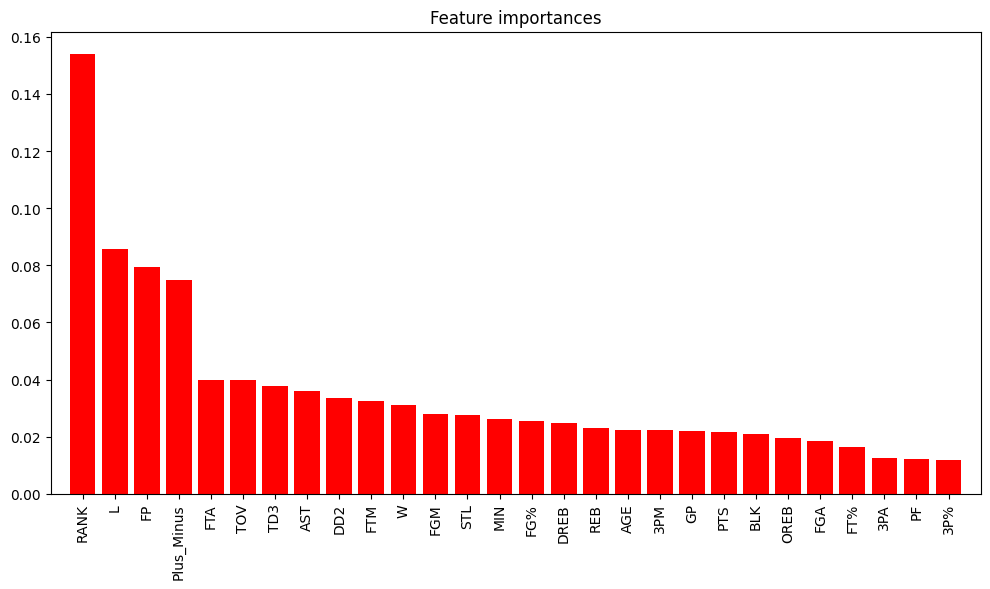

In [119]:
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Execution
## Training

In [120]:
# Train according to top features
threshold = 0.01
top_features = [feature for feature, importance in sorted_features if importance > threshold]

X_selected = X[top_features]

# X_selected

In [121]:
# Split the data with the selected features plus evaluation set
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# print("X_train_selected shape:", X_train_selected.shape)
# print("X_test_selected shape:", X_test_selected.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)

X_train_selected, X_eval, y_train, y_eval = train_test_split(X_train_selected, y_train, test_size=0.25, random_state=42)

# Retrain the model with selected features
xgb_model_selected = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_selected.fit(X_train_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [122]:
# Train model

xgb_model_selected.fit(X_train_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Evaluation

In [123]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1]
}

# Set up the grid search
grid_search = GridSearchCV(xgb_model_selected, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train_selected, y_train)

# Best model
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [124]:
# Cross-validate the model
cv_scores = cross_val_score(best_model, X_selected, y, cv=5, scoring='accuracy')
print("CV Mean Score: ", cv_scores.mean())

CV Mean Score:  0.9968701483591837


In [125]:
# Predict on the test set
y_pred_eval = best_model.predict(X_eval)

# Evaluation metrics
print("Accuracy: ", accuracy_score(y_eval, y_pred_eval))
print("Classification Report (Eval):\n", classification_report(y_eval, y_pred_eval))
print("Confusion Matrix:\n", confusion_matrix(y_eval, y_pred_eval))

Accuracy:  0.996274217585693
Classification Report (Eval):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2674
           1       0.50      0.30      0.38        10

    accuracy                           1.00      2684
   macro avg       0.75      0.65      0.69      2684
weighted avg       1.00      1.00      1.00      2684

Confusion Matrix:
 [[2671    3]
 [   7    3]]


# Prediction

In [126]:
# Predict on the test set
y_pred = best_model.predict(X_test_selected)

# Evaluation metrics
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report (Test):\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy:  0.9955290611028316
Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2677
           1       0.14      0.14      0.14         7

    accuracy                           1.00      2684
   macro avg       0.57      0.57      0.57      2684
weighted avg       1.00      1.00      1.00      2684

Confusion Matrix:
 [[2671    6]
 [   6    1]]


In [127]:
current_season_features = pd.get_dummies(current_season_stats)

for col in X_train_selected.columns:
    if col not in current_season_features.columns:
        current_season_features[col] = 0

# Filter to only use top features
current_season_selected = current_season_features[top_features]


In [128]:
# Predict MVP probabilities
predicted_mvp_probabilities = xgb_model_selected.predict_proba(current_season_selected)[:, 1]

current_season_stats['MVP_Probability'] = predicted_mvp_probabilities

top_mvp_candidates = current_season_stats.sort_values(by='MVP_Probability', ascending=False).head(5)

current_season_stats

/var/folders/ql/xzr3f1fs21gdfhndpz5zd7780000gn/T/ipykernel_6052/3589935121.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_season_stats['MVP_Probability'] = predicted_mvp_probabilities


,RANK,FIRST NAME,LAST NAME,SUFFIX,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,SEASON,Is_MVP,MVP_Probability
0,1,Luka,Doncic,NaN,DAL,25,70,46,24,2624.0,2370,804,1652,48.7,284,744,38.2,478,608,78.6,59,588,647,686,282,99,38,149,4304,49,21,319,2023-24,0,0.437243
1,2,Shai,Gilgeous-Alexander,NaN,OKC,25,75,55,20,2552.7,2254,796,1487,53.5,95,269,35.3,567,649,87.4,65,350,415,465,162,150,67,184,3939,8,0,613,2023-24,0,0.097837
2,3,Giannis,Antetokounmpo,NaN,MIL,29,73,45,28,2567.2,2222,837,1369,61.1,34,124,27.4,514,782,65.7,196,645,841,476,250,87,79,210,4193,57,10,339,2023-24,0,0.001357
3,4,Jalen,Brunson,NaN,NYK,27,77,49,28,2726.3,2212,790,1648,47.9,211,526,40.1,421,497,84.7,43,235,278,519,186,70,13,144,3387,9,0,512,2023-24,0,0.000637
4,5,Nikola,Jokic,NaN,DEN,29,79,55,24,2736.5,2085,822,1411,58.3,83,231,35.9,358,438,81.7,223,753,976,708,237,108,68,194,4609,68,25,682,2023-24,0,0.008768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,258,Kris,Murray,NaN,POR,23,62,12,50,1348.3,376,145,366,39.6,49,183,26.8,37,56,66.1,85,139,224,80,55,53,21,92,932,1,0,-164,2023-24,0,0.000007
266,267,Dyson,Daniels,NaN,NOP,21,61,34,27,1358.5,354,139,311,44.7,42,135,31.1,34,53,64.2,62,174,236,164,59,85,25,101,1154,1,0,71,2023-24,0,0.000008
267,267,Matisse,Thybulle,NaN,POR,27,65,18,47,1487.4,354,126,317,39.7,80,231,34.6,22,29,75.9,30,106,136,90,40,113,49,93,1098,0,0,-232,2023-24,0,0.000022
280,281,Nicolas,Batum,NaN,PHI,35,60,36,24,1529.6,320,116,256,45.3,73,185,39.5,15,21,71.4,70,178,248,128,40,48,38,109,1028,0,0,177,2023-24,0,0.000135


In [129]:
print('Below are the predictions for MVP with eligibility rules for 2023-24 season:\n')
# print('Below are the predictions for MVP with eligibility rules\nand without those with less than 1000 points:\n')
# print('Below are the predictions for MVP with eligibility rules\nand without those with more than 60 rank:\n')
# print('Below are the predictions for MVP with eligibility rules\nand without those with less than 225 +/-:\n')
# print('Below are the predictions for MVP with eligibility rules\nand without those with less than 2000 FP\n')
# print('Below are the predictions for MVP with eligibility rules\nand without those with more than 35 L:\n')
print(top_mvp_candidates[['FIRST NAME', 'LAST NAME', 'TEAM', 'MVP_Probability']])

Below are the predictions for MVP with eligibility rules for 2023-24 season:

    FIRST NAME           LAST NAME TEAM  MVP_Probability
0         Luka              Doncic  DAL         0.437243
1         Shai  Gilgeous-Alexander  OKC         0.097837
4       Nikola               Jokic  DEN         0.008768
225       Kyle               Lowry  PHI         0.002092
194         Al             Horford  BOS         0.001712
